In [12]:
import pandas as pd
import networkx as nx
from math import exp
import matplotlib.pyplot as plt
import numpy as np
from itertools import count

In [13]:
nodes = pd.read_csv('routes.csv', header=None, names=['i', 'j'])
g = nx.from_pandas_edgelist(nodes, 'i', 'j')
print('Number of nodes', g.number_of_nodes())
print('Number of edges', g.number_of_edges())

Number of nodes 151
Number of edges 1851


In [14]:
# We have a dataframe of countries (nodes)
countries = pd.read_csv('data.csv')
countries.set_index('country', inplace=True)
countries['population'] = 1000000*countries['population']
# Travellers are for an entire year, but our timeline is weekly
countries['travellers'] = countries['travellers']/52

countries.head()

,population,travellers,hdi
country,,,
Afghanistan,32760000.0,37113.596154,0.498
Albania,2900000.0,79730.769231,0.773
Algeria,39100000.0,54596.153846,0.747
Angola,26920000.0,23932.519231,0.581
Antigua and Barbuda,98000.0,19996.326923,0.780


In [15]:
# For each country, we need the travellers going from the neighboring countries
def return_list_neighbors(i, g):
    return [j for j in g.neighbors(i)]
print('Albania\'s neighbors :', return_list_neighbors('Albania', g))

# For all countries
def compute_sum_travelers_neighboring_countries(g):
    sum_travel_neighbors = []
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for n in neighbors:
            sum += countries.loc[n]['travellers']
        sum_travel_neighbors.append(sum)
    return sum_travel_neighbors
countries['sum_travel_neighbors'] = compute_sum_travelers_neighboring_countries(g)

countries.head()

Albania's neighbors : ['Austria', 'Germany', 'Greece', 'Italy', 'Slovenia', 'Turkey', 'United Kingdom']


,population,travellers,hdi,sum_travel_neighbors
country,,,,
Afghanistan,32760000.0,37113.596154,0.498,2.739243e+06
Albania,2900000.0,79730.769231,0.773,3.826346e+06
Algeria,39100000.0,54596.153846,0.747,1.192336e+07
Angola,26920000.0,23932.519231,0.581,9.622885e+06
Antigua and Barbuda,98000.0,19996.326923,0.780,6.018484e+06


In [16]:
# W_ij the weight between country i and j represents the number of travellers between i and j
def compute_edge_weight(i, j):
    return countries.loc[i]['travellers']*countries.loc[j]['travellers']/(countries.loc[i]['sum_travel_neighbors'])
        
def add_edge_weights():
    for e in g.edges():
        g[e[0]][e[1]]['weight'] = compute_edge_weight(e[0], e[1])

add_edge_weights()
print('France - Germany :', g['France']['Germany'])
print('France - UK :', g['France']['United Kingdom'])

France - Germany : {'weight': 88582.44661152952}
France - UK : {'weight': 62802.53397113779}


In [17]:
# Initialisation for our model :
r0 = 3
alpha = 0.06
beta = 1
period = 20
mortality_rate = 0.2
country_start = 'France'
nb_infected_start = 100

# # Initialisation for t=0 :
countries['incubation0'] = np.zeros(countries.shape[0])
countries['sick0'] = np.zeros(countries.shape[0])
countries['dead0'] = np.zeros(countries.shape[0])
countries['infected0'] = np.zeros(countries.shape[0])
countries['healthy0'] = countries['population']
# We infect the starting country with a certain number of people
countries.loc[country_start]['infected0'] = nb_infected_start
countries.loc[country_start]['incubation0'] = nb_infected_start
countries.loc[country_start]['healthy0'] = countries.loc[country_start]['population'] - countries.loc[country_start]['incubation0']

The reproduction number ri (average number of people that an incubated person will infect in a week) should :
- be inversly proportionate to the HDI (depending on the beta)
- Decrease with time (as awareness increases, and the immune system adjusts, etc) (depending on the alpha)

In [28]:
# Contamination decreases with time
def time(t):
    return exp(-alpha*t)

# We calculate the average number infected by an incubated person in a week
# The higher the HDI of a country, the less people will be infected
def reproduction_number_by_country(t):
    return (1 -beta*countries['hdi'] + beta)*r0*time(t)

ri = reproduction_number_by_country(1)
print('Country \t HDI \t RI')
print('Afghanistan : \t', countries.loc['Afghanistan']['hdi'], '\t',ri['Afghanistan'])
print('France : \t', countries.loc['France']['hdi'], '\t',ri['France'])

Country 	 HDI 	 RI
Afghanistan : 	 0.498 	 4.243590988330625
France : 	 0.894 	 3.124774722432537


(array([25., 17., 24., 25., 19., 11., 10., 12.,  6.,  2.]),
 array([2.97785946, 3.14511684, 3.31237422, 3.4796316 , 3.64688898,
        3.81414636, 3.98140374, 4.14866112, 4.3159185 , 4.48317589,
        4.65043327]),
 <a list of 10 Patch objects>)

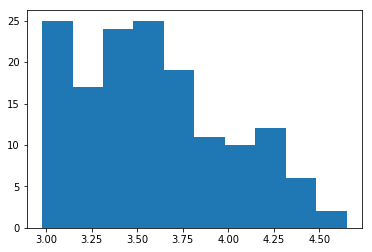

In [21]:
test1 = ((1 -beta*countries['hdi'])*r0 + beta*r0)*exp(-alpha*1)
plt.hist(test1)

(array([25., 17., 24., 25., 19., 11., 10., 12.,  6.,  2.]),
 array([2.34246721, 2.47403653, 2.60560585, 2.73717516, 2.86874448,
        3.00031379, 3.13188311, 3.26345243, 3.39502174, 3.52659106,
        3.65816037]),
 <a list of 10 Patch objects>)

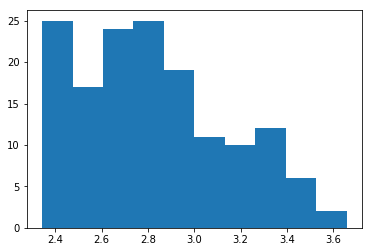

In [23]:
test5 = ((1 -beta*countries['hdi'])*r0 + beta*r0)*exp(-alpha*5)
plt.hist(test5)

In [9]:
# Incubated people staying in the country at time t
def number_incubated_staying(t):
    incubated_staying = {}
    for i in countries.index:
        incubated_staying[i] = countries.loc[i]['incubation'+str(t-1)]*(1 - 
                    countries.loc[i]['travellers']/(countries.loc[i]['healthy'+str(t-1)] - 
                    countries.loc[i]['sick'+str(t-1)]))
    return incubated_staying
# Incubated people coming to the country at time t
def number_incubated_coming(t):
    incubated_coming = {}
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*countries.loc[j]['incubation'+str(t-1)]/(countries.loc[j]['healthy'+str(t-1)] - 
                                                                              countries.loc[j]['sick'+str(t-1)])
        incubated_coming[i] = sum
    return incubated_coming

incubated_coming = number_incubated_coming(1)
print('Number of incubated staying in France :', number_incubated_staying(1)['France'])
print('Number of incubated coming to France :', incubated_coming['France'])
print('Number of incubated coming to Germany :', incubated_coming['Germany'])
print('Number of incubated coming to the UK :', incubated_coming['United Kingdom'])

sum = 0
for n in return_list_neighbors('France', g):
    sum += incubated_coming[n]
print('For all of France\' neighbors :', sum)

Number of incubated staying in France : 98.05177317553934
Number of incubated coming to France : 0.0
Number of incubated coming to Germany : 0.1379791037237278
Number of incubated coming to the UK : 0.09782341401020529
For all of France' neighbors : 2.0675078328777334


In [11]:
def infection_impact(t):
    ri = reproduction_number_by_country(t)
    incubated_staying = number_incubated_staying(t)
    incubated_coming = number_incubated_coming(t)
    
    countries['dead'+str(t)] = mortality_rate*countries['sick'+str(t-1)]
    countries['infected'+str(t)] = [(incubated_staying[i] 
                + incubated_coming[i])*(1 + ri[i]) for i in countries.index]
    
    countries['healthy'+str(t)] = [countries.loc[i]['population'] - countries.loc[i]['infected'+str(t)] for i in countries.index]
    countries['sick'+str(t)] = countries['incubation'+str(t - 1)] 
    countries['incubation'+str(t)] = countries['infected'+str(t)] - countries['sick'+str(t)]

print('Country : \t Infected \t Dead')
for p in range(1, period+1):
    infection_impact(p)
    print(p)
    print('France : \t', round(countries.loc['France']['infected'+str(p)], 3), '\t',
                      round(countries.loc['France']['dead'+str(p)], 3))
    print('Germany : \t', round(countries.loc['Germany']['infected'+str(p)], 3), '\t',
                       round(countries.loc['Germany']['dead'+str(p)], 3))
    print('UK : \t \t', round(countries.loc['United Kingdom']['infected'+str(p)], 3), '\t',
                  round(countries.loc['United Kingdom']['dead'+str(p)], 3))
    print('Afghanistan : \t', round(countries.loc['Afghanistan']['infected'+str(p)], 3), '\t',
                           round(countries.loc['Afghanistan']['dead'+str(p)], 3))

Country : 	 Infected 	 Dead
1
France : 	 335.185 	 0.0
Germany : 	 0.458 	 0.0
UK : 	 	 0.327 	 0.0
Afghanistan : 	 0.0 	 0.0
2
France : 	 755.865 	 20.0
Germany : 	 2.504 	 0.0
UK : 	 	 1.804 	 0.0
Afghanistan : 	 0.005 	 0.0
3
France : 	 1605.777 	 47.037
Germany : 	 8.501 	 0.092
UK : 	 	 6.172 	 0.065
Afghanistan : 	 0.043 	 0.0
4
France : 	 3213.667 	 104.136
Germany : 	 23.495 	 0.409
UK : 	 	 17.187 	 0.295
Afghanistan : 	 0.205 	 0.001
5
France : 	 6058.762 	 217.019
Germany : 	 56.736 	 1.291
UK : 	 	 41.813 	 0.939
Afghanistan : 	 0.765 	 0.007
6
France : 	 10760.344 	 425.714
Germany : 	 123.289 	 3.408
UK : 	 	 91.515 	 2.498
Afghanistan : 	 2.434 	 0.033
7
France : 	 18001.911 	 786.038
Germany : 	 244.759 	 7.939
UK : 	 	 182.947 	 5.864
Afghanistan : 	 6.869 	 0.12
8
France : 	 28369.462 	 1366.03
Germany : 	 447.879 	 16.718
UK : 	 	 337.017 	 12.439
Afghanistan : 	 17.588 	 0.367
9
France : 	 42112.644 	 2234.352
Germany : 	 759.726 	 32.233
UK : 	 	 575.348 	 24.151
A